In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load data 
#cluster_old = pd.read_csv("/dtu/blackhole/1a/222266/clustered_reviews.csv")
cluster = pd.read_csv("/dtu/blackhole/1a/222266/clustered_reviews_pca.csv")


In [3]:
cluster.head()

,row_id,rating,sentiment_score,cluster_kmeans,cluster_dbscan
0,B000HYTF96,5.0,4.471352,3,-1
1,B000Q9I494,5.0,4.711667,3,-1
2,B00085ZGFG,5.0,4.612285,1,-1
3,B000E1EJ3Y,4.0,4.206191,2,-1
4,B0007HVO0Q,1.0,2.503401,4,-1


In [5]:
#print values from cluster dbcsan column
cluster['cluster_dbscan'].value_counts()

cluster_dbscan
-1     498902
 18        49
 11        46
 13        42
 19        41
        ...  
 46        10
 51        10
 62        10
 64        10
 65        10
Name: count, Length: 67, dtype: int64

### Analysis 1: If the cluster are a little bit even distibuted sentiment analysis & minhashing detect more different ratings. (Support this assumption with the choice of k=5 as the best kmean or in general support for k=5 choice)

In [3]:
max_y = max(
    cluster['rating'].value_counts().max(),
    cluster['rating'].value_counts().max()
)

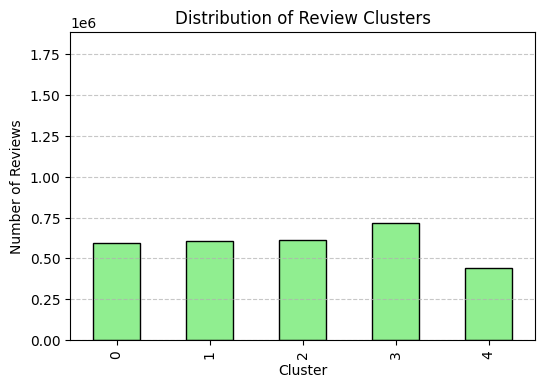

In [4]:
#plot the distribution of clusters
plt.figure(figsize=(6,4))
cluster['cluster'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribution of Review Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.ylim(0, max_y +100000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

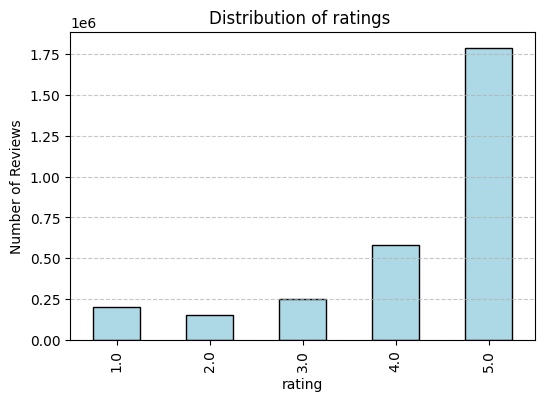

In [5]:
#plot the distribution of clusters
plt.figure(figsize=(6,4))
cluster['rating'].value_counts().sort_index().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Distribution of ratings ")
plt.xlabel("rating")
plt.ylabel("Number of Reviews")
plt.ylim(0, max_y +100000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Analysis 2: Heatmap for rating distribution between cluster

In [6]:
import seaborn as sns

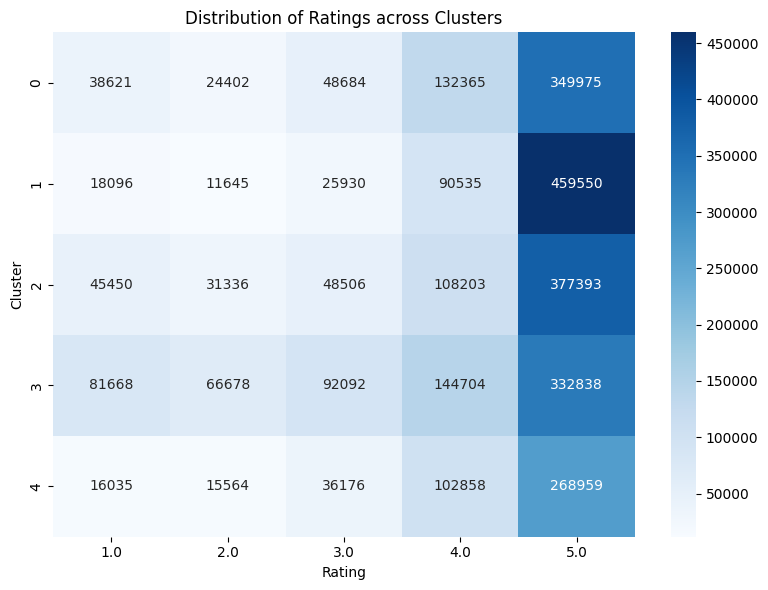

In [7]:
heatmap_data = pd.crosstab(cluster['cluster'], cluster['rating'])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')

plt.title("Distribution of Ratings across Clusters")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

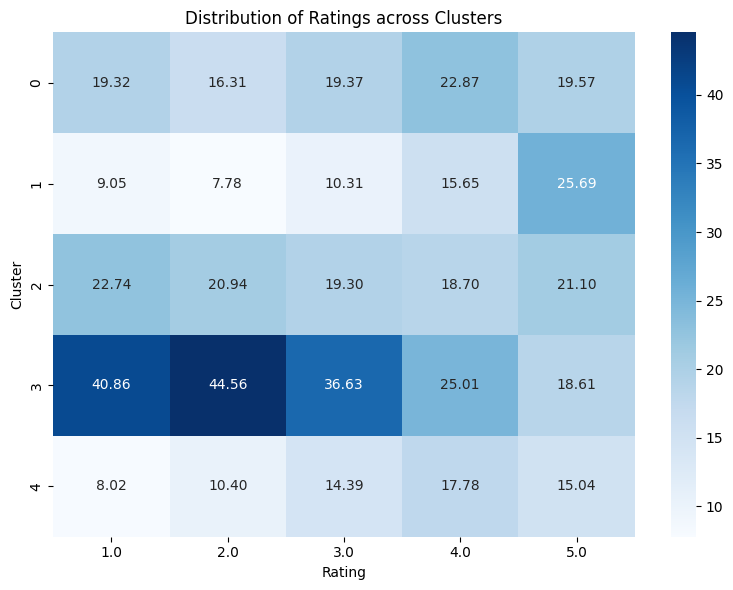

In [8]:

# normalize with account of rating distribution
heatmap_data = pd.crosstab(cluster['cluster'], cluster['rating'], normalize="columns")*100

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Blues')

plt.title("Distribution of Ratings across Clusters")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

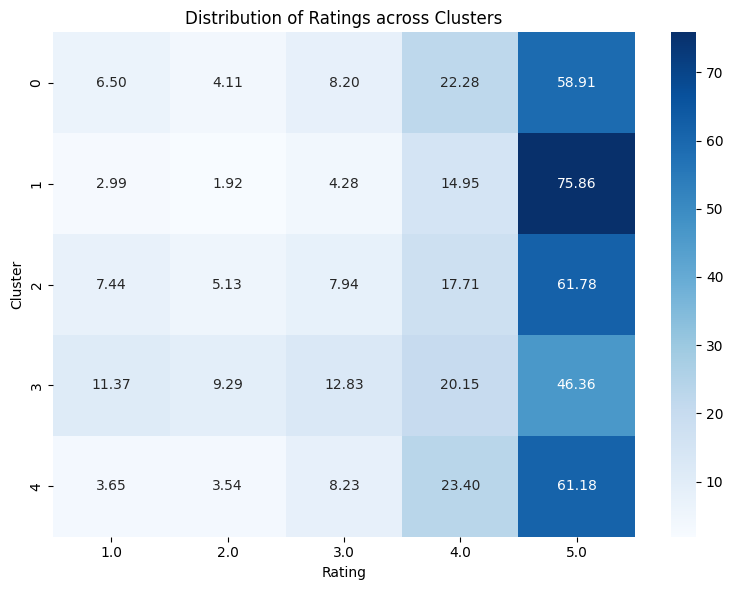

In [9]:
#heatmap_data = pd.crosstab(cluster['cluster'], cluster['rating'])
#heatmap with procentual values
heatmap_data = pd.crosstab(cluster['cluster'], cluster['rating'], normalize='index') * 100

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Blues')

plt.title("Distribution of Ratings across Clusters")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [10]:
print(cluster['cluster'].value_counts().sort_index())

cluster
0    594047
1    605756
2    610888
3    717980
4    439592
Name: count, dtype: int64


### Analyse 3: expected rating per cluster

In [11]:
cluster_stats = cluster.groupby('cluster')['rating'].agg(['mean', 'std']).reset_index()
print(cluster_stats)

   cluster      mean       std
0        0  4.229989  1.169456
1        1  4.587765  0.895397
2        2  4.212584  1.235627
3        3  3.808332  1.396533
4        4  4.349301  1.020803


In [12]:
df = cluster.merge(cluster_stats[['cluster', 'mean', 'std']], on='cluster', how='left')
k = 0.5
df['threshold'] = df['mean'] + k * df['std']
df['is_overrating'] = df['rating'] > df['threshold']


In [13]:
print(df[['rating', 'cluster', 'mean', 'is_overrating']].head(10))

   rating  cluster      mean  is_overrating
0     4.0        4  4.349301          False
1     5.0        0  4.229989           True
2     5.0        0  4.229989           True
3     4.0        0  4.229989          False
4     4.0        0  4.229989          False
5     4.0        0  4.229989          False
6     5.0        0  4.229989           True
7     5.0        2  4.212584           True
8     5.0        2  4.212584           True
9     4.0        2  4.212584          False


In [14]:
overrating_counts = df.groupby('cluster')['is_overrating'].sum().reset_index(name='overrating_count')
total_counts = df.groupby('cluster')['rating'].count().reset_index(name='total_reviews')

In [15]:
result = (
    cluster_stats
    .merge(overrating_counts, on='cluster')
    .merge(total_counts, on='cluster')
)

In [16]:
result['overrating_pct'] = (result['overrating_count'] / result['total_reviews'] * 100).round(1)


In [17]:
print(result)

   cluster      mean       std  overrating_count  total_reviews  \
0        0  4.229989  1.169456            349975         594047   
1        1  4.587765  0.895397                 0         605756   
2        2  4.212584  1.235627            377393         610888   
3        3  3.808332  1.396533            332838         717980   
4        4  4.349301  1.020803            268959         439592   

   overrating_pct  
0            58.9  
1             0.0  
2            61.8  
3            46.4  
4            61.2  
